# Modelagem: comparação de classificadores

Notebook para experimentar **Regressão Logística**, **Random Forest** e **Gradient Boosting**.
Objetivo: identificar qual modelo tem melhor desempenho para prever `TARGET` (1 = defasagem, 0 = ok).

Fluxo:
1. Carregar CSV com dados limpos
2. EDA rápida (target balance, missing)
3. Construir `YEARS_IN_PROGRAM` a partir de `ANO_INGRESSO` (se existir)
4. Preparar pipeline de preprocessamento (imputação + scaling + OHE)
5. CV (StratifiedKFold ou GroupKFold) para comparar ROC-AUC, PR-AUC e F1
6. Treino final no melhor modelo e avaliação no holdout
7. Export do pipeline vencedor (joblib)


In [1]:
# Imports principais (comentados linha-a-linha)
import os                              # manipulação de caminhos
import numpy as np                     # arrays e cálculo numérico
import pandas as pd                    # manipulação de dataframes
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, classification_report, confusion_matrix, precision_score, recall_score
import joblib                           # salvar/recuperar pipeline
import warnings
warnings.filterwarnings("ignore")        # para saídas mais limpas no notebook


In [2]:
# Carregar dataset processado (ajuste o caminho se necessário)
DATA_PATH = '../data/processed_train.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Arquivo não encontrado: {DATA_PATH}")

# 1) Ler CSV
df = pd.read_csv(DATA_PATH)

# 2) Informações iniciais
print("Shape:", df.shape)
print("\nColunas (preview):", df.columns.tolist()[:40])
print("\nExemplo de linhas:")
display(df.head().T)

# 3) TARGET check
TARGET_COL = 'TARGET'
if TARGET_COL not in df.columns:
    raise KeyError(f"Coluna {TARGET_COL} não encontrada. Colunas disponíveis: {list(df.columns)[:200]}")
print("\nDistribuição TARGET:")
print(df[TARGET_COL].value_counts(dropna=False))
print("\nPercentual positivos (TARGET==1): {:.3f}".format(df[TARGET_COL].mean()))


Shape: (860, 18)

Colunas (preview): ['INDE_22', 'IPS', 'IEG', 'IDA', 'IPV', 'IAA', 'ANO_INGRESSO', 'PEDRA_22', 'TARGET', 'INSTITUIÇÃO_DE_ENSINO_Escola Pública', 'INSTITUIÇÃO_DE_ENSINO_Rede Decisão', 'FASE_1', 'FASE_2', 'FASE_3', 'FASE_4', 'FASE_5', 'FASE_6', 'FASE_7']

Exemplo de linhas:


,0,1,2,3,4
INDE_22,5.783,7.055,6.591,5.951,7.427
IPS,5.600,6.300,5.600,5.600,5.600
IEG,4.100,5.200,7.900,4.500,8.600
IDA,4.000,6.800,5.600,5.000,5.200
IPV,7.278,6.778,7.556,5.278,7.389
IAA,8.300,8.800,0.000,8.800,7.900
ANO_INGRESSO,2016.000,2017.000,2016.000,2017.000,2016.000
PEDRA_22,1.000,3.000,2.000,1.000,3.000
TARGET,1.000,0.000,0.000,0.000,0.000
INSTITUIÇÃO_DE_ENSINO_Escola Pública,1.000,0.000,0.000,0.000,0.000



Distribuição TARGET:
TARGET
1    601
0    259
Name: count, dtype: int64

Percentual positivos (TARGET==1): 0.699


In [3]:
# Criar YEARS_IN_PROGRAM a partir de ANO_INGRESSO (proxy temporal) se existir
if 'ANO_INGRESSO' in df.columns:
    ANO_BASE = 2024
    # forçar numeric (coerce invalid -> NaN)
    df['ANO_INGRESSO'] = pd.to_numeric(df['ANO_INGRESSO'], errors='coerce')
    df['YEARS_IN_PROGRAM'] = (ANO_BASE - df['ANO_INGRESSO']).clip(lower=0)
    # flag de missing (útil para modelo)
    df['ANO_INGRESSO_MISS'] = df['ANO_INGRESSO'].isna().astype(int)
    print("YEARS_IN_PROGRAM criado. Exemplos:", df['YEARS_IN_PROGRAM'].unique()[:10])
else:
    print("Coluna ANO_INGRESSO não encontrada; pulando YEARS_IN_PROGRAM.")
    


YEARS_IN_PROGRAM criado. Exemplos: [8 7 3 6 5 4 2]


In [4]:
# Estratégia automática: pegar colunas numéricas (exceto target) e algumas categóricas
# Ajuste manualmente a lista `manual_features` se desejar controlar exatamente.
manual_features = None  # <-- se quiser, defina uma lista com nomes das colunas

# candidatos numéricos
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remover TARGET 
num_cols = [c for c in num_cols if c != 'TARGET']
# detectar categoricals com poucas categorias (úteis)
cat_cols = [c for c in df.select_dtypes(include=['object','category']).columns if c not in id_cols]

print("Candidate numeric features (exemplo):", num_cols[:40])
print("Candidate categorical features (exemplo):", cat_cols[:20])

if manual_features:
    FEATURES = manual_features
else:
    # combinar numericas e categoricas (pode reduzir se houver muitas categorias)
    FEATURES = num_cols + cat_cols

print("Total features usadas:", len(FEATURES))


Candidate numeric features (exemplo): ['INDE_22', 'IPS', 'IEG', 'IDA', 'IPV', 'IAA', 'ANO_INGRESSO', 'PEDRA_22', 'INSTITUIÇÃO_DE_ENSINO_Escola Pública', 'INSTITUIÇÃO_DE_ENSINO_Rede Decisão', 'FASE_1', 'FASE_2', 'FASE_3', 'FASE_4', 'FASE_5', 'FASE_6', 'FASE_7', 'YEARS_IN_PROGRAM', 'ANO_INGRESSO_MISS']
Candidate categorical features (exemplo): []
Total features usadas: 19


In [5]:
# === Passo 6 (substituição) ===
# Holdout simples (sem group split): Stratified se possível; alternativa: split temporal por coorte.

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.20        # ajuste se quiser 10% / 30% etc.
TARGET_COL = 'TARGET'

# X (features) e y (target) - garantir que FEATURES já está definido
X = df[FEATURES].copy()
y = df[TARGET_COL].astype(int).values

# Verificações rápidas da prevalência
n_pos = int(y.sum())
n_total = len(y)
pos_rate = n_pos / n_total
print(f"Total registros: {n_total}, Positivos: {n_pos} ({pos_rate:.3%})")

# Se quiser validação temporal alternativa, setar SPLIT_MODE = 'temporal'
# (usa ANO_INGRESSO ou YEARS_IN_PROGRAM para segurar coortes)
SPLIT_MODE = 'stratified'   # opções: 'stratified' ou 'temporal'

if SPLIT_MODE == 'stratified':
    # Estratificado por TARGET — só funciona bem se houver >=2 exemplos por classe no test set
    # Verificar se a estratificação é segura: cada classe deve ter pelo menos 2 exemplos
    unique, counts = np.unique(y, return_counts=True)
    cls_counts = dict(zip(unique, counts))
    min_count = min(counts)
    if min_count < 5:
        print("Atenção: alguma classe tem menos de 5 exemplos. Estratify pode gerar splits instáveis.")
        print("Será feito split sem estratificação (fallback).")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE, shuffle=True
        )

elif SPLIT_MODE == 'temporal':
    # Exemplo de split temporal por ANO_INGRESSO (treinar em coortes antigas, testar em coortes recentes)
    # Requer que df tenha 'ANO_INGRESSO' ou 'YEARS_IN_PROGRAM' já criada.
    if 'ANO_INGRESSO' in df.columns:
        # definir threshold (ex.: testar em cohorts >= 2022)
        TEST_FROM_YEAR = 2022
        train_mask = (df['ANO_INGRESSO'] < TEST_FROM_YEAR)
        test_mask  = (df['ANO_INGRESSO'] >= TEST_FROM_YEAR)
        X_train, y_train = X.loc[train_mask], y[train_mask.values]
        X_test,  y_test  = X.loc[test_mask],  y[test_mask.values]
        print(f"Temporal split: train years < {TEST_FROM_YEAR} | test years >= {TEST_FROM_YEAR}")
    else:
        raise KeyError("SPLIT_MODE='temporal' exigiu coluna 'ANO_INGRESSO' que não existe no dataframe.")

else:
    raise ValueError("SPLIT_MODE inválido. Use 'stratified' ou 'temporal'.")

# Informações finais
print("Shapes -> X_train, X_test:", X_train.shape, X_test.shape)
import pandas as _pd
print("TARGET dist (train):")
print(_pd.Series(y_train).value_counts(normalize=False).to_dict())
print("TARGET dist (test):")
print(_pd.Series(y_test).value_counts(normalize=False).to_dict())

# Salvar índices do holdout (opcional, útil para reprodutibilidade)
# OBS: se X_train/X_test são slices com índices do df, podemos salvar
try:
    train_idx = X_train.index.tolist()
    test_idx  = X_test.index.tolist()
    # salvar como csv para referência
    import json
    with open('../data/holdout_idx.json', 'w') as fh:
        json.dump({'train_idx': train_idx, 'test_idx': test_idx}, fh)
    print("Índices do holdout salvos em ../data/holdout_idx.json")
except Exception as e:
    print("Não foi possível salvar índices do holdout:", e)


Total registros: 860, Positivos: 601 (69.884%)
Shapes -> X_train, X_test: (688, 19) (172, 19)
TARGET dist (train):
{1: 481, 0: 207}
TARGET dist (test):
{1: 120, 0: 52}
Índices do holdout salvos em ../data/holdout_idx.json


In [6]:
# Separar features numéricas e categóricas na lista selecionada
# Alias para compatibilidade:
# Se num_cols já existir:
numeric_features = num_cols
categorical_features = cat_cols

# Se elas NÃO existirem, crie do zero:
if 'numeric_features' not in locals():
    # Remover target das features numericas
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'TARGET' in numeric_features:
        numeric_features.remove('TARGET')
        
    categorical_features = df.select_dtypes(include=['object','category']).columns.tolist()
    # Remover IDs se necessário (exemplo)
    id_cols = ['ID_ALUNO'] # Ajuste se precisar
    categorical_features = [c for c in categorical_features if c not in id_cols]

# Atualizar para garantir consistência
num_cols = numeric_features
cat_cols = categorical_features

print(f"Features numéricas: {len(numeric_features)}")
print(f"Features categóricas: {len(categorical_features)}")



Features numéricas: 19
Features categóricas: 0


In [7]:
# Definir 3 modelos (parâmetros básicos; depois testar tuning)
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

# Observação: se quiser tentar LightGBM (opcional), substitua GradientBoosting por LGBMClassifier (import lightgbm).


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Certifique-se de que num_cols e cat_cols estão definidos
# Se não estiverem, use o bloco anterior que mandei para defini-los
print(f"Features Numéricas: {len(num_cols)}")
print(f"Features Categóricas: {len(cat_cols)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop' # Ignorar colunas que não estão nessas listas
)

print("Preprocessor definido com sucesso.")

Features Numéricas: 19
Features Categóricas: 0
Preprocessor definido com sucesso.


In [9]:
# Função auxiliar: calcular PR-AUC a partir de y_true e probabilidades
# === Passo 9 (corrigido, robusto) ===
from sklearn.model_selection import StratifiedKFold, GroupKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import numpy as np

def pr_auc_score(y_true, y_scores):
    pr, rc, _ = precision_recall_curve(y_true, y_scores)
    return auc(rc, pr)

# Determinar se há agrupamento: aceitar GROUP_COL se foi definido anteriormente e existir no df
GROUP_COL = globals().get('GROUP_COL', None)  # pega GROUP_COL se existir no scope, senão None
use_groups = False
if GROUP_COL is not None and GROUP_COL in df.columns:
    use_groups = True
    print("GROUP_COL encontrado e será utilizado para GroupKFold:", GROUP_COL)
else:
    print("Nenhum GROUP_COL válido encontrado. Usando StratifiedKFold (sem agrupamento).")
    GROUP_COL = None

cv_results = {}
cv = GroupKFold(n_splits=5) if use_groups else StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# iterar modelos
for name, clf in models.items():
    print("\n--- CV (OOF) para:", name, '---')
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])
    
    try:
        if use_groups:
            # pegar grupos correspondentes às linhas de X_train (X_train tem índices do df)
            groups_train = df.loc[X_train.index, GROUP_COL]
            # O cross_val_predict exige arrays alinhados com X_train
            y_proba_oof = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1, groups=groups_train)[:,1]
            y_oof_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict', n_jobs=-1, groups=groups_train)
        else:
            y_proba_oof = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:,1]
            y_oof_pred = cross_val_predict(pipe, X_train, y_train, cv=cv, method='predict', n_jobs=-1)
    except Exception as e:
        print("Erro ao executar cross_val_predict para", name, "->", e)
        # fallback: tentar cross_validate (métricas médias) ou pular
        from sklearn.model_selection import cross_validate
        scoring = {'roc_auc':'roc_auc', 'f1':'f1'}
        cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        cv_results[name] = {'roc_auc_oof': float(np.mean(cv_res['test_roc_auc'])), 'f1_oof': float(np.mean(cv_res['test_f1'])), 'pr_auc_oof': np.nan}
        print(f"Resultado fallback para {name} (médias): ROC-AUC {cv_results[name]['roc_auc_oof']:.4f}, F1 {cv_results[name]['f1_oof']:.4f}")
        continue

    # calcular métricas OOF
    roc = roc_auc_score(y_train, y_proba_oof)
    pr  = pr_auc_score(y_train, y_proba_oof)
    f1  = f1_score(y_train, y_oof_pred)
    prec = precision_score(y_train, y_oof_pred)
    rec  = recall_score(y_train, y_oof_pred)

    cv_results[name] = {'roc_auc_oof': roc, 'pr_auc_oof': pr, 'f1_oof': f1, 'precision_oof': prec, 'recall_oof': rec}
    print(f"ROC-AUC (oof): {roc:.4f}  PR-AUC (oof): {pr:.4f}  F1 (oof): {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}")


Nenhum GROUP_COL válido encontrado. Usando StratifiedKFold (sem agrupamento).

--- CV (OOF) para: LogisticRegression ---
ROC-AUC (oof): 0.9998  PR-AUC (oof): 0.9999  F1 (oof): 0.9948  Prec: 0.9917  Rec: 0.9979

--- CV (OOF) para: RandomForest ---
ROC-AUC (oof): 0.8916  PR-AUC (oof): 0.9317  F1 (oof): 0.8999  Prec: 0.8598  Rec: 0.9439

--- CV (OOF) para: GradientBoosting ---
ROC-AUC (oof): 0.9484  PR-AUC (oof): 0.9690  F1 (oof): 0.9411  Prec: 0.9205  Rec: 0.9626


In [10]:
# Escolher melhor modelo segundo métrica prioritária (ex.: PR-AUC)
best_model_name = max(cv_results.keys(), key=lambda n: cv_results[n]['pr_auc_oof'])
print("Melhor modelo (CV, por PR-AUC):", best_model_name)

# Treinar pipeline completo no train set
best_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', models[best_model_name])])
best_pipe.fit(X_train, y_train)

# Previsões no holdout
y_prob_test = best_pipe.predict_proba(X_test)[:,1]
y_pred_test = best_pipe.predict(X_test)

# Métricas no teste
roc_test = roc_auc_score(y_test, y_prob_test)
pr_test = pr_auc_score(y_test, y_prob_test)
f1_test = f1_score(y_test, y_pred_test)
print("\nDesempenho no holdout:")
print(f"ROC-AUC: {roc_test:.4f}")
print(f"PR-AUC:  {pr_test:.4f}")
print(f"F1:      {f1_test:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_test))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_test))

# Salvar pipeline (modelo pronto)
OUT_MODEL = '../data/best_pipeline.joblib'
joblib.dump(best_pipe, OUT_MODEL)
print("Pipeline salvo em:", OUT_MODEL)


Melhor modelo (CV, por PR-AUC): LogisticRegression

Desempenho no holdout:
ROC-AUC: 1.0000
PR-AUC:  1.0000
F1:      1.0000

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00       120

    accuracy                           1.00       172
   macro avg       1.00      1.00      1.00       172
weighted avg       1.00      1.00      1.00       172


Confusion matrix:
[[ 52   0]
 [  0 120]]
Pipeline salvo em: ../data/best_pipeline.joblib


In [11]:
# Tentar extrair nomes das features pós-preprocessing

from sklearn.inspection import permutation_importance
from sklearn.utils.validation import check_is_fitted

OUT_DIR = '/../data'
os.makedirs(OUT_DIR, exist_ok=True)

def extract_feature_names_from_column_transformer(ct, input_features=None):
    """
    Retorna nomes das features após ColumnTransformer `ct`.
    input_features: lista de nomes originais (opcional), usada quando cols são slices/strings.
    """
    feature_names = []
    try:
        transformers = ct.transformers_  # exige que o ColumnTransformer já esteja fitado
    except Exception as e:
        raise RuntimeError("ColumnTransformer precisa estar fitado (fit) dentro do pipeline.") from e

    for name, transformer, cols in transformers:
        # ignorar remainder
        if name == 'remainder':
            continue
        # se o transformer foi definido como 'drop', pular
        if transformer == 'drop':
            continue

        # resolver lista original de colunas
        if isinstance(cols, (list, tuple, np.ndarray)):
            orig_cols = list(cols)
        else:
            # cols pode ser slice ou string; tentar usar input_features se fornecido
            if input_features is not None:
                if isinstance(cols, slice):
                    orig_cols = input_features[cols]
                else:
                    orig_cols = [cols]
            else:
                orig_cols = [cols]

        # se for Pipeline, pegar o último estimador
        last_transformer = transformer
        if hasattr(transformer, 'steps'):
            last_transformer = transformer.steps[-1][1]

        # Caso 1: OneHotEncoder (nova API)
        if hasattr(last_transformer, 'get_feature_names_out'):
            try:
                # passada lista de orig_cols (nome de input)
                names = last_transformer.get_feature_names_out(orig_cols)
                feature_names.extend(list(names))
                continue
            except Exception:
                pass

        # Caso 2: OneHotEncoder antigo com categories_
        if hasattr(last_transformer, 'categories_'):
            cats = last_transformer.categories_
            # categories_ deve corresponder a cada orig_col
            for col, cat_vals in zip(orig_cols, cats):
                for cat in cat_vals:
                    feature_names.append(f"{col}_{cat}")
            continue

        # Caso 3: transformer que não altera cardinalidade — manter orig_cols
        feature_names.extend(orig_cols)

    # remover duplicatas mantendo ordem
    seen = set()
    uniq = []
    for f in feature_names:
        if f not in seen:
            uniq.append(f)
            seen.add(f)
    return uniq

# --- garantir que best_pipe existe e esteja treinado ---
try:
    pre_final = best_pipe.named_steps['pre']
    clf_final = best_pipe.named_steps['clf']
except Exception as e:
    raise RuntimeError("best_pipe não encontrado ou não tem passos 'pre' e 'clf'. Assegure que 'best_pipe' existe e foi treinado.") from e

# garantir fit
check_is_fitted(pre_final)
check_is_fitted(clf_final)

# tentar extrair nomes
input_features = FEATURES if 'FEATURES' in globals() else (X_train.columns.tolist() if 'X_train' in globals() else None)
try:
    feature_names = extract_feature_names_from_column_transformer(pre_final, input_features=input_features)
    print(f"Extraídas {len(feature_names)} feature names após preprocessor.")
except Exception as e:
    print("Falha ao extrair nomes de features diretamente:", e)
    # fallback genérico
    X_sample = pre_final.transform(X_train.head(3))
    n_trans = X_sample.shape[1]
    feature_names = [f"f_{i}" for i in range(n_trans)]
    print(f"Fallback: gerados {n_trans} nomes genéricos (f_0..f_{n_trans-1}).")

# conferir tamanho real transformado
X_trans_sample = pre_final.transform(X_train.head(1))
n_transformed = X_trans_sample.shape[1]
if len(feature_names) != n_transformed:
    print(f"Atenção: #names ({len(feature_names)}) != #features transformadas ({n_transformed}). Ajustando/fazendo fallback.")
    # ajustar ou preencher com nomes genéricos
    if len(feature_names) > n_transformed:
        feature_names = feature_names[:n_transformed]
    else:
        feature_names = feature_names + [f"f_{i}" for i in range(len(feature_names), n_transformed)]

# Agora extrair importâncias/coefs
if hasattr(clf_final, 'feature_importances_'):
    importances = clf_final.feature_importances_
    df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    df_imp = df_imp.sort_values('importance', ascending=False).reset_index(drop=True)
    display(df_imp.head(30))
    df_imp.to_csv(os.path.join(OUT_DIR, 'feature_importances.csv'), index=False)
    print("Feature importances salvas em:", os.path.join(OUT_DIR, 'feature_importances.csv'))

elif hasattr(clf_final, 'coef_'):
    coefs = clf_final.coef_
    # shape: (1, n_features) ou (n_classes, n_features)
    if coefs.ndim == 1:
        arr = coefs
    elif coefs.shape[0] == 1:
        arr = coefs.ravel()
    else:
        arr = np.mean(np.abs(coefs), axis=0)
    df_coef = pd.DataFrame({'feature': feature_names, 'coef': arr})
    df_coef['abs_coef'] = df_coef['coef'].abs()
    df_coef = df_coef.sort_values('abs_coef', ascending=False).reset_index(drop=True)
    display(df_coef.head(30))
    df_coef.to_csv(os.path.join(OUT_DIR, 'feature_coef.csv'), index=False)
    print("Coefs salvos em:", os.path.join(OUT_DIR, 'feature_coef.csv'))

else:
    # fallback caro: permutation importance (funciona para qualquer estimador)
    print("Estimador não expõe importances/coef. Calculando permutation importance (pode demorar)...")
    # transformar X_test via pre_final
    X_eval = pre_final.transform(X_test)
    try:
        res = permutation_importance(clf_final, X_eval, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    except Exception as e:
        print("Permutation importance com n_jobs=-1 falhou, tentando n_jobs=1:", e)
        res = permutation_importance(clf_final, X_eval, y_test, n_repeats=10, random_state=42, n_jobs=1)
    df_perm = pd.DataFrame({'feature': feature_names, 'importance': res.importances_mean})
    df_perm = df_perm.sort_values('importance', ascending=False).reset_index(drop=True)
    display(df_perm.head(30))
    df_perm.to_csv(os.path.join(OUT_DIR, 'feature_perm_importance.csv'), index=False)
    print("Permutation importances salvas em:", os.path.join(OUT_DIR, 'feature_perm_importance.csv'))

print("Passo 11 concluído.")


Extraídas 19 feature names após preprocessor.


,feature,coef,abs_coef
0,INDE_22,-8.614049,8.614049
1,IDA,3.912999,3.912999
2,IEG,3.010008,3.010008
3,IPV,2.687344,2.687344
4,IAA,1.762411,1.762411
5,PEDRA_22,-1.377494,1.377494
6,IPS,0.997227,0.997227
7,FASE_3,0.634463,0.634463
8,FASE_4,0.574676,0.574676
9,FASE_1,0.546177,0.546177


Coefs salvos em: /../data\feature_coef.csv
Passo 11 concluído.


In [12]:
#Calibração forçada em regressão logistica
from sklearn.calibration import CalibratedClassifierCV

# 1. Pegar o melhor estimador do Tuning (ou criar um novo se não rodou o tuning)
# Se você já rodou o search, use: best_lr = best_models['LogisticRegression']
# Caso contrário, defina um com bons parâmetros padrão:
best_lr = LogisticRegression(C=1.0, penalty='l2', max_iter=1000, random_state=42)

# 2. Pipeline Específico
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_lr)
])

# 3. Calibração
# method='sigmoid' (Platt Scaling) costuma funcionar bem para LogReg 
# method='isotonic' se tiver MUITOS dados
calibrated_lr = CalibratedClassifierCV(
    lr_pipeline['classifier'], 
    method='sigmoid', 
    cv=5
)

final_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('calibrated_classifier', calibrated_lr)
])

final_pipeline_lr.fit(X_train, y_train)
print("Regressão Logística calibrada com sucesso.")

Regressão Logística calibrada com sucesso.


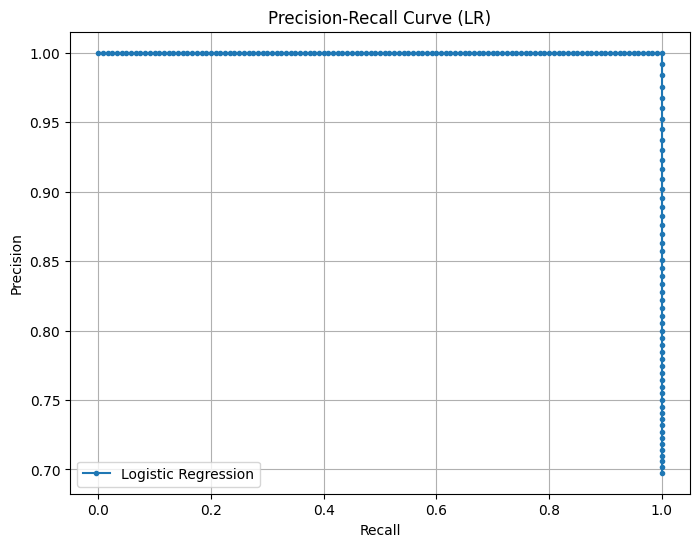

Threshold Otimizado (Recall ~90.0%): 0.9421
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        52
           1       1.00      0.90      0.95       120

    accuracy                           0.93       172
   macro avg       0.91      0.95      0.92       172
weighted avg       0.94      0.93      0.93       172



In [13]:
# Seleção do Treshold
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt

y_proba_lr = final_pipeline_lr.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.title('Precision-Recall Curve (LR)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

# Priorizando Recall (ex: pegar min 90%)
min_recall = 0.90
idx = np.where(recall >= min_recall)[0][-1]
opt_threshold_lr = thresholds[idx] if idx < len(thresholds) else 0.5

print(f"Threshold Otimizado (Recall ~{min_recall*100}%): {opt_threshold_lr:.4f}")

# Previsão final
y_pred_opt_lr = (y_proba_lr >= opt_threshold_lr).astype(int)
print(classification_report(y_test, y_pred_opt_lr))

In [16]:
import shap
import pandas as pd
import scipy.sparse
import numpy as np

# A. Análise de Coeficientes (Global)
print("Transformando dados de treino...")
# Ajustamos o preprocessor e obtemos os dados transformados
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# PROTEÇÃO CONTRA ERRO: Converter matriz esparsa para densa (numpy array)
# O SHAP frequentemente falha com matrizes esparsas (geradas pelo OneHotEncoder)
if scipy.sparse.issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()

# Treinar Regressão Logística para explicação usando os dados transformados
modelo_para_explicar = LogisticRegression(C=1.0, max_iter=1000).fit(
    X_train_transformed, 
    y_train
)

# Nomes das features
try:
    # Tenta usar o método nativo do sklearn (mais seguro)
    feature_names = list(preprocessor.get_feature_names_out())
except AttributeError:
    # Fallback apenas se a versão do sklearn for muito antiga
    try:
        feature_names = get_feature_names(preprocessor)
    except:
        feature_names = [f"feat_{i}" for i in range(X_train_transformed.shape[1])]

# Ajuste de segurança final: se o número de nomes não bater, gerar genéricos
if len(feature_names) != X_train_transformed.shape[1]:
    print(f"Aviso: {len(feature_names)} nomes encontrados para {X_train_transformed.shape[1]} colunas. Usando nomes genéricos.")
    feature_names = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]

# Criar DataFrame de coeficientes
try:
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coeficiente': modelo_para_explicar.coef_[0]
    }).sort_values(by='Coeficiente', key=abs, ascending=False)

    print("Top 10 Features mais impactantes (Coeficientes):")
    display(coef_df.head(10))
except Exception as e:
    print(f"Não foi possível exibir tabela de coeficientes: {e}")

# B. SHAP (LinearExplainer)
print("\nIniciando cálculo do SHAP...")
try:
    # Transformar dados de teste
    X_test_trans = preprocessor.transform(X_test)
    
    # Converter teste também para denso, se necessário
    if scipy.sparse.issparse(X_test_trans):
        X_test_trans = X_test_trans.toarray()

    # Resumir dados de fundo (background) usando kmeans nos dados DENSOS
    # Usamos 10 centróides para performance (o cálculo é pesado)
    background = shap.kmeans(X_train_transformed, 10) 

    explainer = shap.LinearExplainer(modelo_para_explicar, background)
    shap_values = explainer.shap_values(X_test_trans)

    print("SHAP Summary Plot (Impacto na decisão):")
    shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)
except Exception as e:
    print(f"Erro ao gerar gráfico SHAP: {e}")
    import traceback
    traceback.print_exc()

Transformando dados de treino...
Top 10 Features mais impactantes (Coeficientes):


,Feature,Coeficiente
0,num__INDE_22,-8.295824
3,num__IDA,3.798856
2,num__IEG,2.898380
4,num__IPV,2.602409
5,num__IAA,1.697586
7,num__PEDRA_22,-1.405020
1,num__IPS,0.973453
12,num__FASE_3,0.587951
13,num__FASE_4,0.543749
10,num__FASE_1,0.531422



Iniciando cálculo do SHAP...
Erro ao gerar gráfico SHAP: The Linear explainer only supports the Independent, Partition, and Impute maskers right now!


Traceback (most recent call last):
  File "C:\Users\mtmal\AppData\Local\Temp\ipykernel_3644\2395011880.py", line 64, in <module>
    explainer = shap.LinearExplainer(modelo_para_explicar, background)
  File "d:\Arquivos Baixados\onedrive\FIAP\Dataton-1\.venv\Lib\site-packages\shap\explainers\_linear.py", line 137, in __init__
    raise NotImplementedError(
        "The Linear explainer only supports the Independent, Partition, and Impute maskers right now!"
    )
NotImplementedError: The Linear explainer only supports the Independent, Partition, and Impute maskers right now!


In [17]:
# Validação LOCO-CV com Regressão Logística
years = sorted(df['ANO_INGRESSO'].dropna().unique())
metrics_loco = []

print("LOCO-CV (Logistic Regression):")
print(f"{'Ano Teste':<10} | {'ROC-AUC':<10} | {'F1':<10} | {'Train/Test Size':<20}")

for year in years:
    train_mask = df['ANO_INGRESSO'] != year
    test_mask = df['ANO_INGRESSO'] == year
    
    if test_mask.sum() < 10: continue

    X_tr = df.loc[train_mask, FEATURES]
    y_tr = df.loc[train_mask, TARGET_COL]
    X_te = df.loc[test_mask, FEATURES]
    y_te = df.loc[test_mask, TARGET_COL]
    
    # Treino rápido sem recalibrar tudo (ou use o pipeline completo se preferir rigor)
    pipeline_loco = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ])
    
    pipeline_loco.fit(X_tr, y_tr)
    
    probs = pipeline_loco.predict_proba(X_te)[:, 1]
    preds = pipeline_loco.predict(X_te) # Aqui usa threshold 0.5 padrão
    
    auc_val = roc_auc_score(y_te, probs) if len(set(y_te)) > 1 else 0.5
    f1_val = f1_score(y_te, preds, zero_division=0)
    
    print(f"{int(year):<10} | {auc_val:.4f}     | {f1_val:.4f}     | {len(X_tr)}/{len(X_te)}")
    metrics_loco.append(auc_val)

print(f"Média ROC-AUC: {np.mean(metrics_loco):.4f}")

LOCO-CV (Logistic Regression):
Ano Teste  | ROC-AUC    | F1         | Train/Test Size     
2016       | 1.0000     | 1.0000     | 831/29
2017       | 1.0000     | 0.9583     | 820/40
2018       | 1.0000     | 1.0000     | 793/67
2019       | 1.0000     | 1.0000     | 721/139
2020       | 1.0000     | 1.0000     | 812/48
2021       | 1.0000     | 0.9904     | 722/138
2022       | 0.9979     | 0.9852     | 461/399
Média ROC-AUC: 0.9997
